- https://datascienceschool.net/view-notebook/ea4584bde04140368950ee50ef038833/

In [60]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Sampling

- 베이지안 네트워크 = Full joint distribution
- $N$개의 Sample 들이 우리가 알고 있는 Sampling distribution $S$에서 발생한다.
- Sample 들로 부터 approximate posterior probabilirt $\hat{P}$를 구한다.
- 우리가 목표로 하는 Target Probability $P$에 converge 하는지를 찾아본다.

## Forward Sampling (Prior-Sample)

베이지안 네트워크의 topological order 에 따라서 Sample을 Generate 하게 됩니다. 실제 샘플링을 한 다음에, 각 노드의 경우의 수를 count 하게 됩니다. 그 count를 기반으로 확률 분포를 만듭니다. 

$S_{PS}(x_{1},...x_{n})$  = $\Pi^{n}_{i=1}P(x_{i}|Parents(X_{i}))$ = $P(x_{1},...x_{n})$
<br>

즉, Forward Sampling 으로 부터의 estimation은 consistent하다.

$
\lim \limits_{x \to \infty}\hat{P}(x_{1},...,x_{n})≈P(x_1,...,x_{n})
$

In [2]:
# GMN 의 파라미터와 true value setting

pi_true = np.array([0.35,0.45,0.2])
mu_true = np.array([-2,1,5])
sigma_true = np.array([0.9,0.3,0.7])

N = 30000
obs = np.zeros(N)

In [20]:
for i in range(N):
    # 0~1 사이의 임의의 실수를 선택, z는 값, idx, tempSum을 가진다.
    z = np.random.random_sample()
    idx = 0
    tempSum = 0
    
    # z가 속한 범위에 따라 Hyperparamerter의 index를 결정하는 과정
    for j in range(np.size(pi_true)):
        if ((z > tempSum) & (z<=tempSum + pi_true[j])):
            idx = j
            break
        else:
            tempSum = tempSum + pi_true[j]
        
    # x 에 대한 샘플링 과정
    # 샘플링한 z에 대응하는 평균과 공부산을 갖는 다변수 가우스 분포에서 x를 다시 샘플링
    
    v_temp = np.random.normal(mu_true[idx],sigma_true[idx], 1)
    obs[i] = v_temp

/Users/seungheondoh/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


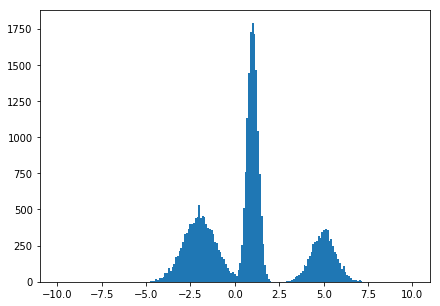

In [13]:
plt.figure(1, figsize=(7,5))
plt.hist(obs, bins=np.linspace(-10,10,20/0.1))
plt.show()

## Rejection Sampling

rejection sampling 방법에서는 목표 확률분포 $p(x)$와 유사하지만 표본생성이 쉬운 유사 확률 분포 $q(x)$를 사용한다.
- $p(x)$ : 샘플링하고싶은 목표 확률 분포
- $q(x)$ : 샘플링 가능한 유사 확률분포
일단 유사 확률분포 $q(x)$의 표본을 생성한 다음에, $p(z)/kq(z)$의 확률로 이 표본을 채택할 것인지 버릴지를 결정한다. 이 때, k는 유사 확률 분포가 목표 확률 분포를 커버하는 스케일링 상수이다. $kq(x) \geq p(x)$

![img](images/04.reject.png)

In [4]:
a = 2
b = 6
rv_p = sp.beta(a, b)
rv_q = sp.norm(loc=0.5, scale=0.5)
k = 5

np.random.seed(0)
x_q0 = rv_q.rvs(int(1e4))
x_q = x_q0[(x_q0 >= 0) & (x_q0 <= 1)]
crits = rv_p.pdf(x_q) / (rv_q.pdf(x_q) * k)
coins = np.random.rand(len(x_q))
x_p = x_q[coins < crits]

In [8]:
x_q0, len(x_q0)

(array([1.38202617, 0.7000786 , 0.98936899, ..., 0.75843609, 0.48353965,
        1.14905572]), 10000)

/Users/seungheondoh/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


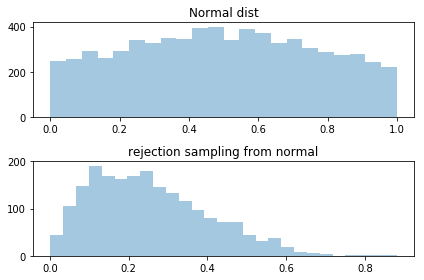

In [5]:
plt.subplot(211)
sns.distplot(x_q, kde=False)
plt.title("Normal dist")
plt.subplot(212)
sns.distplot(x_p, kde=False)
plt.title("rejection sampling from normal")
plt.tight_layout()
plt.show()

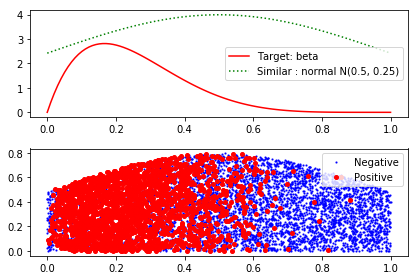

In [3]:
plt.subplot(211)
xx = np.linspace(0, 1, 100)
plt.plot(xx, rv_p.pdf(xx), 'r-', label="Target: beta")
plt.plot(xx, rv_q.pdf(xx) * k, 'g:', label="Similar : normal N(0.5, 0.25)")
plt.legend()
plt.subplot(212)
y = np.random.rand(len(x_q)) * rv_q.pdf(x_q)
plt.plot(x_q, y, 'bs', ms=1, label="Negative")
ids = coins < crits
plt.plot(x_q[ids], y[ids], 'ro', ms=4, label="Positive")
plt.legend()
plt.tight_layout()
plt.show()

## Importance Sampling

원하는 확률값이나 기댓값을 구하는것을 목표로 하는 Sampling입니다. Forward와 Rejection Sampling이 Sampling된 결과를 바탕으로 히스토그램을 그려서 pdf를 나타냈다면, Importance 는 확률값과 기댓값을 구함으로써 계산량을 줄여 나갑니다.
- rejection sampling에 비해 버리는 표본이 없기 때문에 더 효율적인 방법이다.

#### Goal : 확률 모델의 기대값을 구하자!

확률 모델의 확률변수 z와 이의 distribution p(z)이 있을 경우, 임의의 함수 f(z)에 대한 기댓값은 정의에 따라 아래와 같이 구할 수 있습니다.
$$\mathrm{E}[f(z)] = \int f(z)p(z)\,dz$$

그러나 현재 단계에서 Z의 distribution p(z)를 알 수 없으므로 우리가 잘 알고 있는 새로운 함수 q(z)를 도입하여 식을 전개해보면 아래와 같습니다.
$$\mathrm{E}[f(z)] = \int f(z)p(z)\,dz = \int f(z) \frac{p(z)}{q(z)} q(z)\, dz \cong \frac{1}{L}\sum_{l=1}^L \frac{p(z_l)}{q(z_l)}f(z_l)$$
위의 유도 과정의 마지막 부분은 q(z)dz를 Normalizing constant $\frac{1}{L}$로, 적분을 finite sum으로 바꾸어 근사하였습니다. 위와 같은 근사가 가능한 이유는 무한대로 많은 z에 대한 확률 계산이 포함된 적분을 더 이상 전개할 순 없지만, z값이 어떤 값으로 주어졌다면 이의 정확한 p(z)를 구하는 것은 가능하기 때문입니다.        
이때 위의 finite sum에서 sample $z_l$의 함수값 $f(z_l)$에 곱해진 값은 $f(z_l)$의 weight로 해석할 수 있습니다. 이를 우리는 Importance Weight로 정의하며 아래와 같이 표현합니다.
$$r_l = \frac{p(z_l)}{q(z_l)}$$

마찬가지의 아이디어와 방법으로 Importance Sampling으로 확률 모델의 확률값을 구하는 방법을 아래와 같습니다. 
$$P(z>1) = \int 1_{z>1}p(z)\,dz = \int 1_{z>1} \frac{p(z)}{q(z)} q(z)\, dz \cong \frac{1}{L}\sum_{l=1}^L \frac{p(z_l)}{q(z_l)}1_{z_l>1}$$
$1_(z>1)$은 indicator function을 의미하며 z>1인 z에 대해서는 $1_(z>1)(z)=1$, z$leq$1인 z에 대해서는 $1_(z>1)(z)=0$을 갖는 함수입니다.

## Markov Chain

상태값이 K인 유한한 값만 가질 수 있는 이산 상태(discrete-state) 시계열 확률 과정에서 시간 $t$의 $x_{t}$의 확률분포 $p(x_{t})$가 시간 $t-1$의 값의 확률분포 $p_{t-1}$과 조건부 확률분포 $p(x_{t}|p_{t-1})$에만 의존하면 이 시계열 확률 과정을 마코프 체인이라고 한다.
<br>

확률변수 $x_{t}$의 상태가 변화함은 전의행렬(Transition matrix)로 표현이 가능하다. 
$$
T_{i,j} = P(x_{t}=j|x_{t-1}=i)
$$

전치행렬이 대칭행렬인 마코프 체인을 reversible Markov chain 혹은 detailed balance condition을 만족합니다. 이러한 마코프 체인은 시간의 흐름에 따라 초기 조건을 넘어 늘 같은 분포인 $p_{\infty}$ 로 수렴하게 됩니다.

$$
p_{t'}=p_{t+1'}=p_{t+2'}=...=p_{\infty}
$$

$t'$는 수렴상태에 도달한 이후 시간을 뜻합니다. 따라서 수렴상태에 도달한 이후에의 나오는 표본은 모두 같은 확률 분포에서 나온 독립적인 값이 됩니다. 이때를 $i.i.d$(independent and identical distribution) 를 충족한다고 합니다.

## MCMC

Markov chain의 수렴 분포가 원하는 분포 $p(x)$ 가 되도록하는 마코프 체인을 만들고 이 마코프 체인을 $t'$시간 이상 가동하면 원하는 분포의 표본이 된다.

## Metropolis-Hasting 알고리즘

Metropolis-Hastings 알고리즘은 MCMC(Markov Chain Monte Carlo)에서 Stationary probability π만 주어졌을 경우, 주어진 π에 맞는 transition matrix를 구하는 알고리즘입니다.  

- $q(x)$ : 계산용 분포 $q$로 무조건부 분표 $q(x^{*}|x_{t})$
- $P(x)$

1. $t=0$ 일때 무작위로 $x_{t}$를 생성합니다.
2. 그 다음 표본 생성이 가능한 샘플링분포 $q(x^{*}|x_{t})$ 에서 표본 $x^{*}$ 를 생성합니다.
3. 다음 확률에 따라 $x^{*}$를 $x_{t+1}$로 선택합니다. 이를 Acceptance probability 라고 합니다.

$$
\alpha = min \left(1, \frac{P(x^{*})q(x_{t}|x^{*})}{P(x_{t})q(x^{*}|x_{t})}\right)
$$
4. $\alpha$을 통해 $\alpha$의 확률로 해당 후보를 $z_{t+1}$로 Accept ($z_{t+1}=z_*$) or 1-$\alpha$의 확률로 reject ($z_{t+1}=z_t$)합니다. 

위의 과정을 반복하는 것이 MCMC의 일반적인 알고리즘입니다. $p(x^{*})$ 가 $p(x_{t})$ 보다 크게 만들려고 노력합니다.
우리에게 주어진 latent variable($z$)의 확률 밀도함수 $p(x)$와 임의로 결정하는 Proposal distribution q가 있습니다. MCMC는 statinary probability에서 알맞는 transition matrix를 찾기 위해 계산하는 관정입니다.
<br>

1. Reversible Markcov Chain을 만족하는지 체크해야합니다.
2. $q(x)$가 과연 Balance equation을 만족하는가?
$$
r(z^{*}|z^{t})= \frac{P(x^{*})q(x_{t}|x^{*})}{P(x_{t})q(x^{*}|x_{t})} = 1
$$
3. 위 조건을 맞추기 위해서, 업데이트가 진행된다.

In [85]:
pi_true = np.array([0.35,0.45,0.2])
mu_true = np.array([-2,1,5])
sigma_true = np.array([0.9,0.3,0.7])

In [82]:
N = 30000

# 랜덤워크의 움직임 폭을 의마한, 분포를 넓게 돌면서 생플링이 이루어진다, 초기에는 넓게 잡고 점차 줄여나가야한다.
sigma_assumed = 30
sample = np.zeros(N)
idx = np.zeros(N)
idx = idx.astype(int)
sample[0] = 0 
idx[0] = 1

In [87]:
pi_true[0]

0.35

In [92]:
for i in range(1,N):
    # 0,1,2 중 하나의 값이 랜덤하게 나온다
    idx[i] = np.random.random_integers(3)-1
    # z_i 를 sampling 한다. normal distribution 에서, 분산을 40으로 뽑느다
    sample[i] = np.random.normal(sample[i],sigma_assumed, 1)
    # P(z_i)를 추출한다. 
    p_t = pi_true[idx[i]] * sp.multivariate_normal.pdf(sample[i],mu_true[idx[i]], sigma_true[idx[i]])
    # q_t = q(z_i | z_{i-1})
    q_t = sp.multivariate_normal.pdf(sample[i], sample[i-1], sigma_assumed)
    p_t_1 =pi_true[idx[i-1]] * sp.multivariate_normal.pdf(sample[i-1],mu_true[idx[i-1]], sigma_true[idx[i-1]])
    q_t_1 = sp.multivariate_normal.pdf(sample[i-1], sample[i], sigma_assumed)
    
    # Acceptance Probability : alpha = min(1, r)
    alpha = (p_t*q_t) / (p_t_1*q_t_1)
    if alpha > 1:
        alpha = 1
    
    # 알파를 이용해서 z_*를 z_{t+1}로 업데이트 할지를 여부한다.
    # u = [0,1]에서 임의로 실수로 선택하여 구간에 따라 여부를 판별한다.
    u = np.random.uniform(0,1,1)[0]
    if u >= alpha:
        sample[i] = sample[i-1]
        idx[i] = idx[i-1]

/Users/seungheondoh/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(1, 3 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/seungheondoh/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


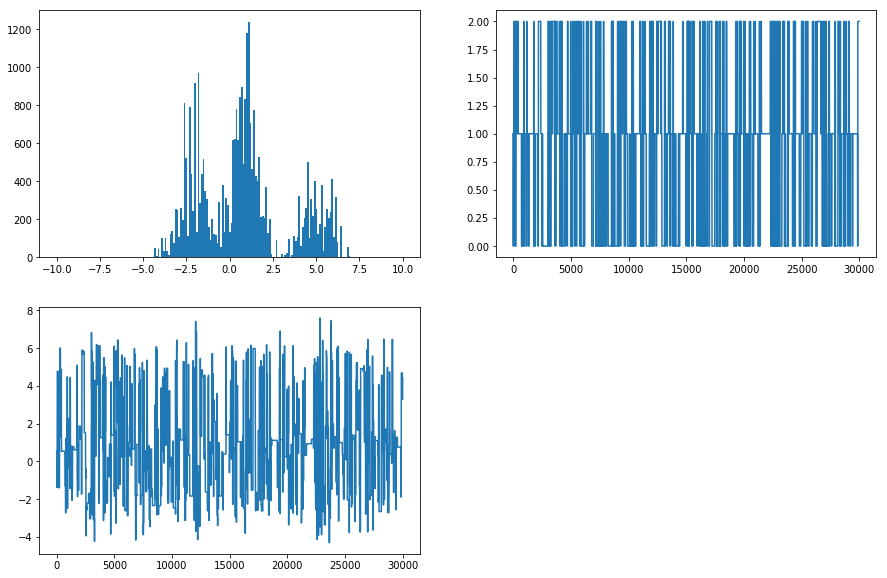

In [93]:
# mixture distribution 을 히스토그램으로 나타냅니다.
plt.figure(1, figsize=(15,10))
plt.subplot(2,2,1)
plt.hist(sample, bins=np.linspace(-10,10,20/0.1))

# z에 대한 샘플링의 결과입니다. - pi 의 분포가 나오겠죠?
plt.subplot(2,2,2)
plt.plot(np.arange(N), idx)

# x에 대한 sampling 결과입니다.
plt.subplot(2,2,3)
plt.plot(np.arange(N), sample)
plt.show()

## Gibbs Sampling

나머지 변수는 고정시킨 채, 하나의 변수만을 변화시킨다. 이때 불필요한 일부 변수를 샘플링 과정에서 제외하는 방법이다. MCMC의 경우 N 차원의 점에서, N차원의 점으로 모든 차원을 한번에 이동시키는 샘플링을 진행한 것인 반면, 깁스 샘플링은 하나의 차원을 제외한나머지는 고정시키고, 한 차원 식 샘플링을 해서 총 N번의 이동을 하고 난 다음에, 새로운 데이터를 샘플링한다. 즉 각 차원에 대한 조건부확률을 알아야 사용이 가능하다.

##### Gibbs Sampling in LDA

- z : Topic - Cluster
- 